# Adult Classification #

**Adult Dataset**:https://archive.ics.uci.edu/dataset/2/adult

**Goal**: Predict whether an adult's income exceedds $50,000/year based on census data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import re

from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.utils import resample

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

## Step 1: Import and Adjust Dataset ##

In [2]:
#Manually adding headers to the data
headers = ["Age", "Workclass", "Fnlwgt", "Education", "Education-Num", "Marital-Status", "Occupation", "Relationship", "Race", "Sex", "Capital-Gain", "Capital-Loss", "Hours-Per-Week", "Native-Country", "Income"]

data = pd.read_csv('adult.data.csv', header = None, names = headers)

#Preview the data
data.head()

,Age,Workclass,Fnlwgt,Education,Education-Num,Marital-Status,Occupation,Relationship,Race,Sex,Capital-Gain,Capital-Loss,Hours-Per-Week,Native-Country,Income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
#Manually drop redundant/unncessary rows of data

#Fnlwgt ("final weight" - the number of people the census thinks this represents) is irrelevant
data = data.drop("Fnlwgt", axis=1)
#Education-num is the same as education, but on a numerical scale
data = data.drop("Education", axis=1)
#Marital status and relationship are redundant 
data = data.drop("Relationship", axis=1)
#Race is a sensitive topic and assigning numerical values to it would be insensitive
data = data.drop("Race", axis=1)
#The same logic applies for native country
data = data.drop("Native-Country", axis=1)
data = data.drop("Capital-Gain", axis=1)
data = data.drop("Capital-Loss", axis=1)

#Preview the updated data
data.head()

,Age,Workclass,Education-Num,Marital-Status,Occupation,Sex,Hours-Per-Week,Income
0,39,State-gov,13,Never-married,Adm-clerical,Male,40,<=50K
1,50,Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Male,13,<=50K
2,38,Private,9,Divorced,Handlers-cleaners,Male,40,<=50K
3,53,Private,7,Married-civ-spouse,Handlers-cleaners,Male,40,<=50K
4,28,Private,13,Married-civ-spouse,Prof-specialty,Female,40,<=50K


In [4]:
#Assess datatypes in the dataset - mix of strings and ints
print(data.dtypes)

#Check for any NaN values in the dataset - no NaNs!
data[data.isnull().any(axis=1)]

Age                int64
Workclass         object
Education-Num      int64
Marital-Status    object
Occupation        object
Sex               object
Hours-Per-Week     int64
Income            object
dtype: object


,Age,Workclass,Education-Num,Marital-Status,Occupation,Sex,Hours-Per-Week,Income


In [5]:
#Use the label encoder function of SKlearn to do convert categorical data
#via ordinal encoding

lb_Make = LabelEncoder()
data["Workclass"] = lb_Make.fit_transform(data["Workclass"])
data["Marital-Status"] = lb_Make.fit_transform(data["Marital-Status"])
data["Occupation"] = lb_Make.fit_transform(data["Occupation"])
#Female = 0, Male = 1
data["Sex"] = lb_Make.fit_transform(data["Sex"])
#<=50K = 0, >=50K = 1
data["Income"] = lb_Make.fit_transform(data["Income"])
data.head()

,Age,Workclass,Education-Num,Marital-Status,Occupation,Sex,Hours-Per-Week,Income
0,39,7,13,4,1,1,40,0
1,50,6,13,2,4,1,13,0
2,38,4,9,0,6,1,40,0
3,53,4,7,2,6,1,40,0
4,28,4,13,2,10,0,40,0


In [6]:
#Cut down size to only 10,000 random samples
data = data.sample(n=10000).reset_index(drop=True)

#Convert dataset to Numpy array
data = data.values

#Preview the data
print(data[0:5,:])

[[28  4  4  4  1  1 40  0]
 [56  4  6  0  8  0 45  0]
 [53  7  9  2 11  1 40  0]
 [76  0 10  6  0  0 40  0]
 [42  2  9  6 14  0 40  0]]


## Step 2: Defining Classifiers ##

In [7]:
global count 
count = 0
def draw_heatmap(acc, acc_desc, C_list, character):
    global count
    plt.figure(figsize = (2,4))
    ax = sns.heatmap(acc, annot=True, fmt='.3f', yticklabels=C_list, xticklabels=[])
    ax.collections[0].colorbar.set_label("Accuracy")
    ax.set(ylabel='$'  + character + '$')
    plt.title(acc_desc + ' w.r.t $' + character + '$')
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()
    count+=1

In [8]:
#Decision Tree (DT) Classifier
def decision_tree(X_train_val, Y_train_val, X_test, Y_test):
    D_list = np.array([1, 2, 3, 4, 5])
    parameters = {'max_depth':D_list}
    
    #Finding the optimal model
    classifier_grid = GridSearchCV(DecisionTreeClassifier(criterion="entropy"), parameters, cv=5, return_train_score=True)
    
    #Fit classifier with training data
    classifier_grid.fit(X_train_val, Y_train_val)
    
    #Training + validation accuracy
    DT_train_acc = classifier_grid.cv_results_['mean_train_score']
    DT_val_acc = classifier_grid.cv_results_['mean_test_score']

    #Train + test model with best parameter
    D_best_param = classifier_grid.best_params_['max_depth']
    classifier_test = DecisionTreeClassifier(max_depth=D_best_param, criterion="entropy")
    classifier_test.fit(X_train_val, Y_train_val)
    
    for i,j in enumerate(D_list):
        if j == D_best_param:
            DT_best_train_acc = DT_train_acc[i]
    
    #Test accuracy
    DT_test_acc = classifier_test.score(X_test,Y_test)
            
    #Training + validation accuracy heatmaps
    draw_heatmap(DT_train_acc.reshape(5,1), 'DT train accuracy', D_list, 'D')
    draw_heatmap(DT_val_acc.reshape(5,1), 'DT val accuracy', D_list, 'D')
    
    return DT_test_acc, DT_best_train_acc, D_best_param

In [9]:
#KNN Classifier
def knn_classifier(X_train_val, Y_train_val, X_test, Y_test):
    K_list = np.array([1, 2, 3, 4, 5, 6])
    parameters = {'n_neighbors':K_list}
    
    #Finding the optimal model
    classifier_grid = GridSearchCV(KNeighborsClassifier(), parameters, cv=5, return_train_score=True)
    
    #Fit classifier with training data
    classifier_grid.fit(X_train_val, Y_train_val)
    
    #Training + validation accuracy
    KNN_train_acc = classifier_grid.cv_results_['mean_train_score']
    KNN_val_acc = classifier_grid.cv_results_['mean_test_score']

    #Train + test model with best parameter
    K_best_param = classifier_grid.best_params_['n_neighbors']
    classifier_test2 = KNeighborsClassifier(n_neighbors=K_best_param)
    classifier_test2.fit(X_train_val,Y_train_val)
    
    for i,j in enumerate(K_list):
        if j == K_best_param:
            KNN_best_train_acc = KNN_train_acc[i]
    
    #Test accuracy
    KNN_test_acc = classifier_test2.score(X_test,Y_test)
    
    #Training + validation accuracy heatmaps
    draw_heatmap(KNN_train_acc.reshape(6,1), 'KNN train accuracy', K_list, 'K')
    draw_heatmap(KNN_val_acc.reshape(6,1), 'KNN val accuracy', K_list, 'K')
    
    return KNN_test_acc, KNN_best_train_acc, K_best_param

In [10]:
#Random Forest Classifier
def random_forest(X_train_val, Y_train_val, X_test, Y_test):
    D_list = np.array([1, 2, 3, 4, 5])
    parameters = {'max_depth':D_list}
    
    #Finding the optimal model
    classifier_grid = GridSearchCV(RandomForestClassifier(criterion="entropy"), parameters, cv=5, return_train_score=True)
    
    #Fit classifier with training data
    classifier_grid.fit(X_train_val, Y_train_val)
    
    #Training + validation accuracy
    RF_train_acc = classifier_grid.cv_results_['mean_train_score']
    RF_val_acc = classifier_grid.cv_results_['mean_test_score']

    #Train + test model with best parameter
    D_best_param = classifier_grid.best_params_['max_depth']
    classifier_test1 = RandomForestClassifier(max_depth=D_best_param, criterion="entropy")
    classifier_test1.fit(X_train_val, Y_train_val)
    
    for i,j in enumerate(D_list):
        if j == D_best_param:
            RF_best_train_acc = RF_train_acc[i]
    
    #Test accuracy
    RF_test_acc = classifier_test1.score(X_test,Y_test)
    
    #Training + validation accuracy heatmaps
    draw_heatmap(RF_train_acc.reshape(5,1), 'RF train accuracy', D_list, 'K')
    draw_heatmap(RF_val_acc.reshape(5,1), 'RF val accuracy', D_list, 'K')
    
    return RF_test_acc, RF_best_train_acc, D_best_param

In [11]:
#SVM Linear Classification
def svm_linear(X_train_val, Y_train_val, X_test, Y_test):
    classifier = svm.SVC(kernel = 'linear')
    C_list = [10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 1]
    parameters = {'C': C_list}
    
    #Finding the optimal model
    clf = GridSearchCV(classifier, parameters, return_train_score=True, cv=5)
    
    #Fit classifier with training data
    clf.fit(X_train_val, Y_train_val)
    
    #Training + validation accuracy
    SVM_train_acc = clf.cv_results_['mean_train_score']
    SVM_val_acc = clf.cv_results_['mean_test_score']

    #Find the optimal C parameter 
    C_best_param = clf.best_params_['C']
    optimal_classifier = svm.SVC(kernel = 'linear', C=C_best_param)
    SVM_best_train_acc = None
    
    for i,j in enumerate(C_list):
        if j == C_best_param:
            SVM_best_train_acc = SVM_train_acc[i]
            break
            
    #Redefining the optimal classifier
    optimal_classifier.fit(X_train_val, Y_train_val)
    
    #Test accuracy
    SVM_test_acc = optimal_classifier.score(X_test, Y_test)

    #Training + validation accuracy heatmaps
    draw_heatmap(SVM_train_acc.reshape(-1,1), 'SVM Linear train accuracy', C_list, 'C')
    draw_heatmap(SVM_val_acc.reshape(-1,1), 'SVM Linear val accuracy', C_list, 'C')

    return SVM_test_acc, SVM_best_train_acc, C_best_param

## Step 3: Perform Classification ##

Partition:  0.2
(2000, 7) (8000, 7) (2000,) (8000,)


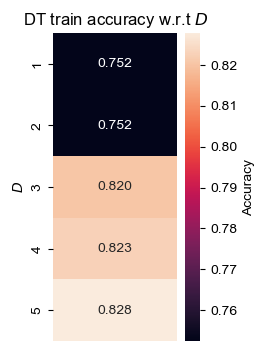

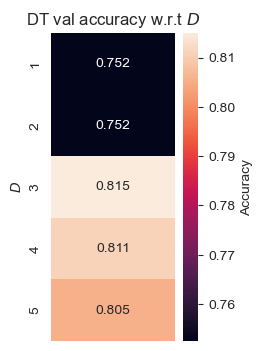

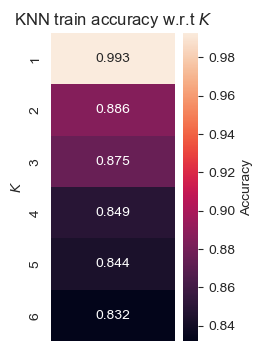

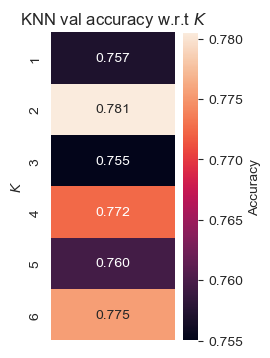

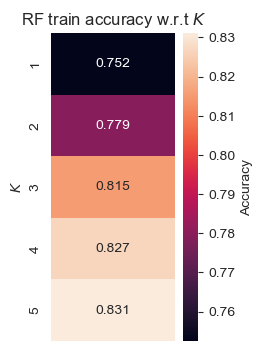

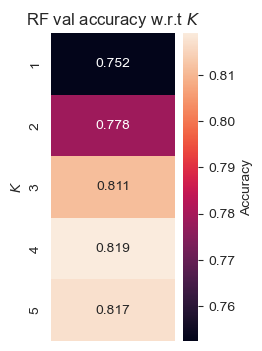

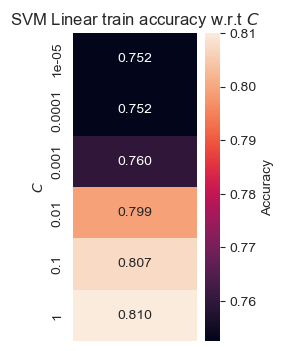

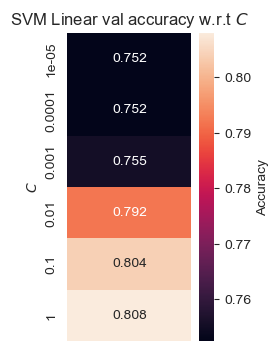

Trial # =  1
(2000, 7) (8000, 7) (2000,) (8000,)


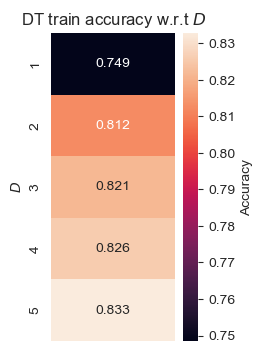

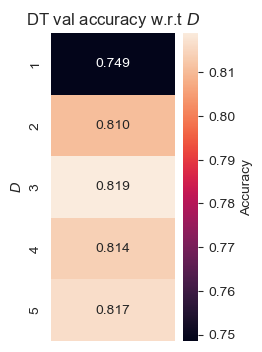

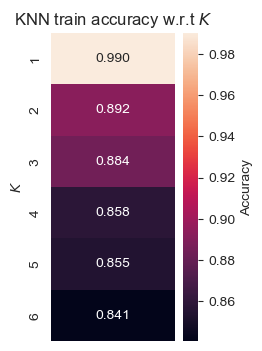

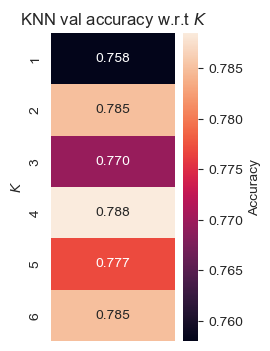

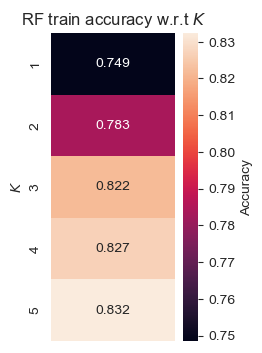

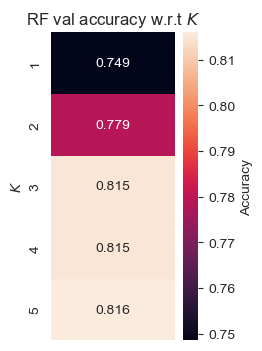

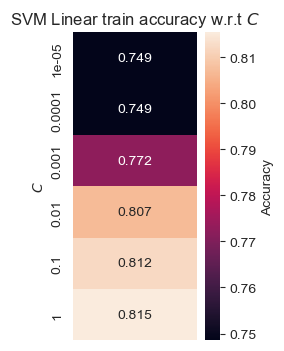

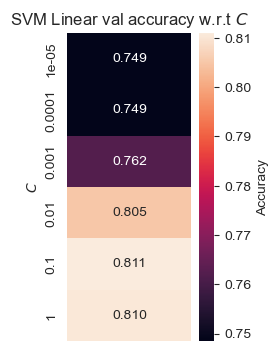

Trial # =  2
(2000, 7) (8000, 7) (2000,) (8000,)


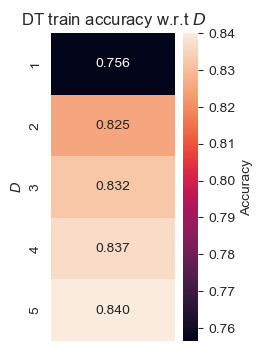

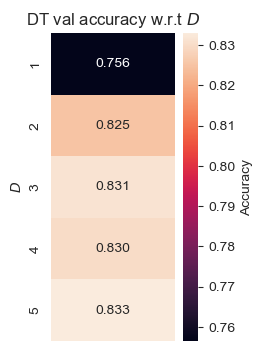

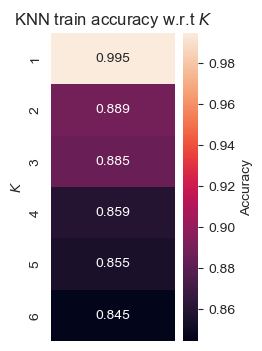

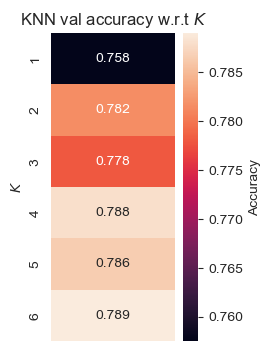

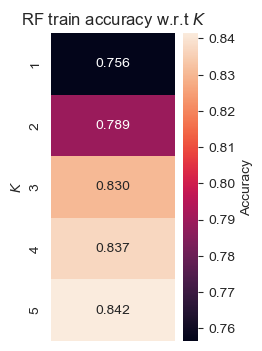

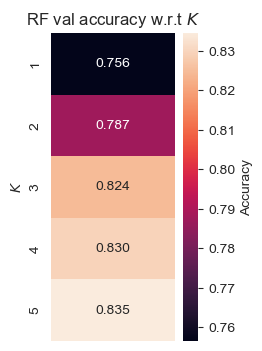

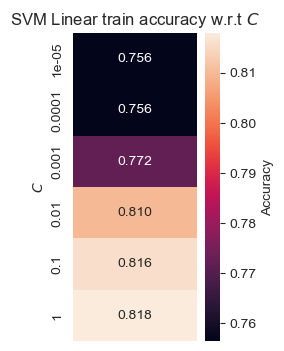

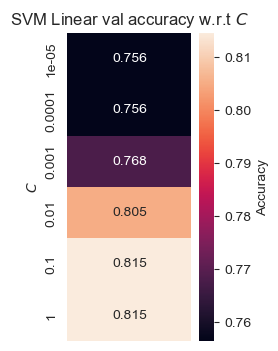

Trial # =  3
Avg Test Accuracy for Decision Tree (DT) =  0.8236250000000002
Avg Test Accuracy for KNN =  0.7840000000000001
Avg Test Accuracy for Random Forest =  0.8230833333333333
Avg Test Accuracy for SVM Linear =  0.8134583333333333
Partition:  0.5
(5000, 7) (5000, 7) (5000,) (5000,)


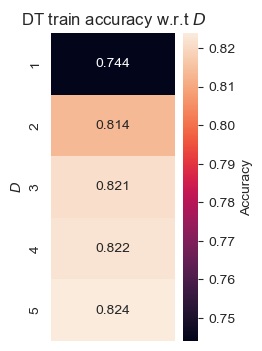

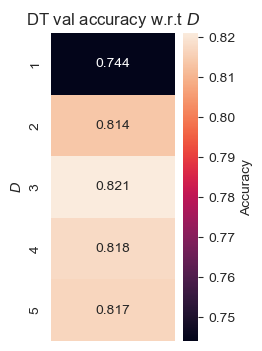

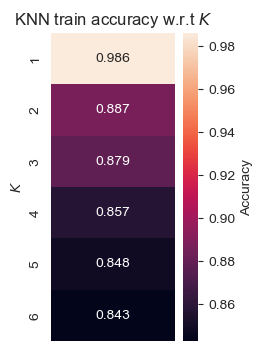

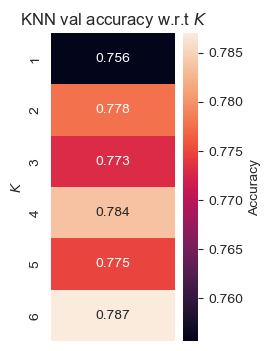

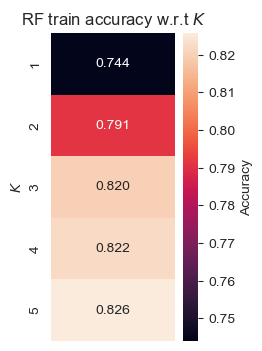

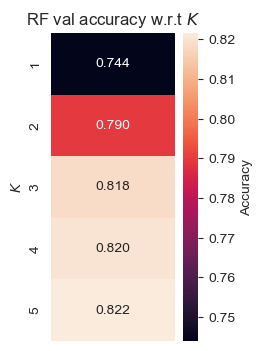

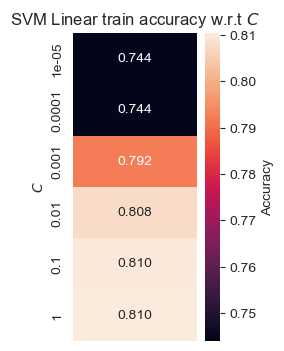

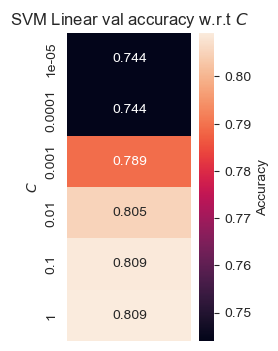

Trial # =  1
(5000, 7) (5000, 7) (5000,) (5000,)


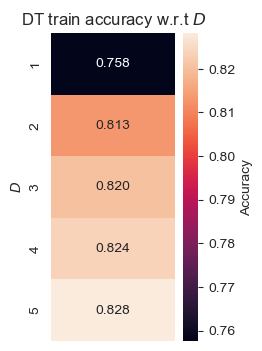

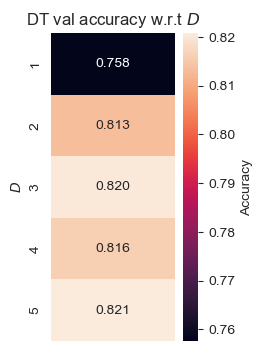

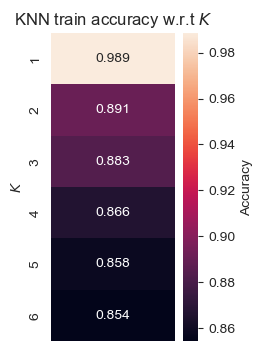

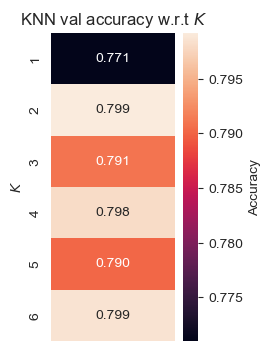

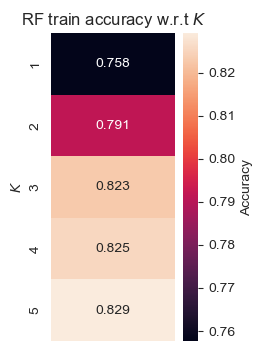

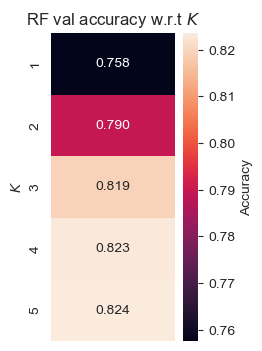

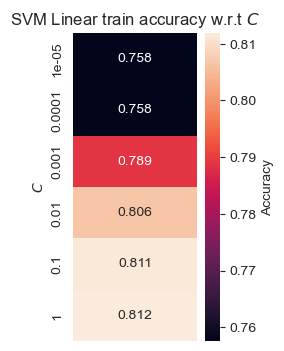

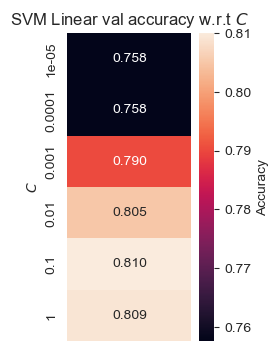

Trial # =  2
(5000, 7) (5000, 7) (5000,) (5000,)


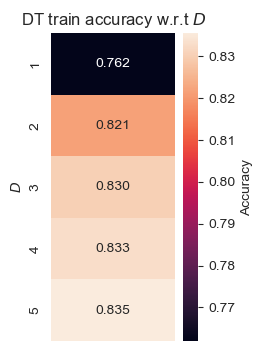

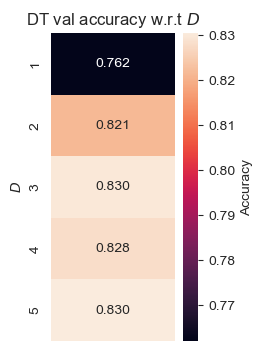

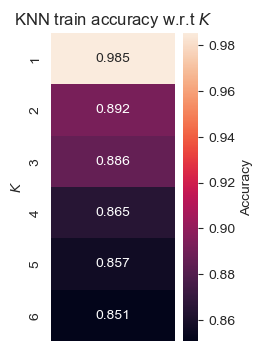

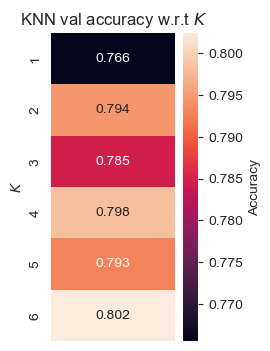

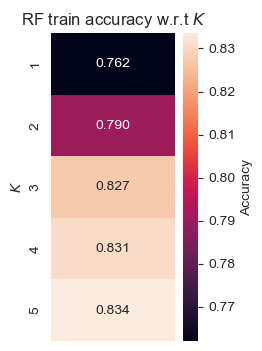

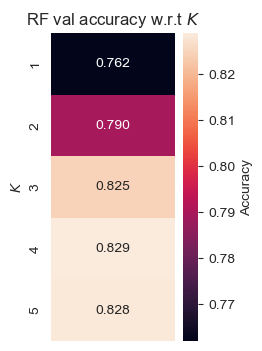

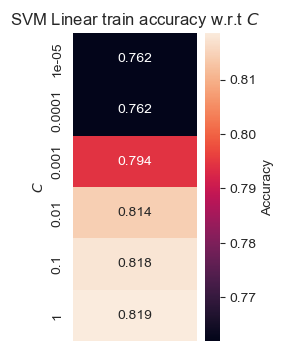

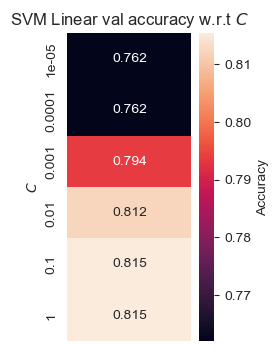

Trial # =  3
Avg Test Accuracy for Decision Tree (DT) =  0.8245999999999999
Avg Test Accuracy for KNN =  0.7957333333333333
Avg Test Accuracy for Random Forest =  0.8242666666666666
Avg Test Accuracy for SVM Linear =  0.8128666666666667
Partition:  0.8
(8000, 7) (2000, 7) (8000,) (2000,)


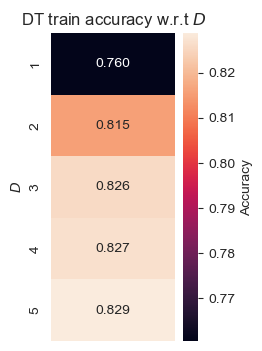

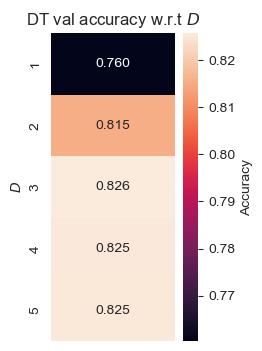

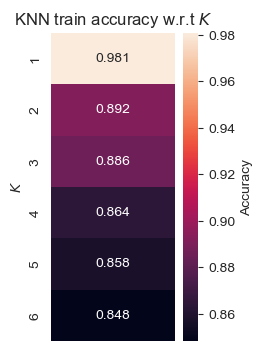

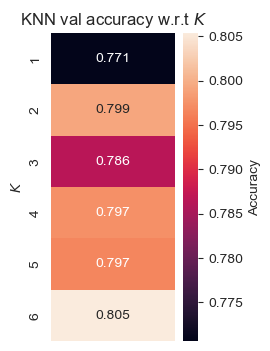

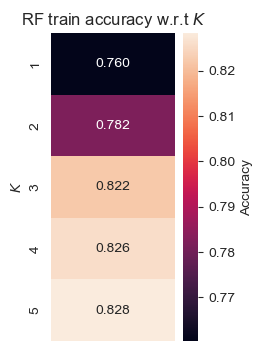

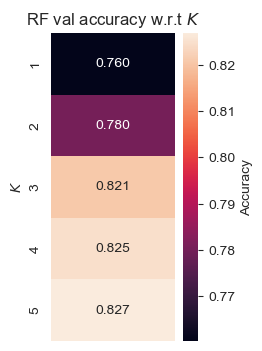

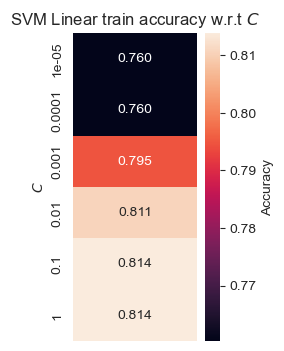

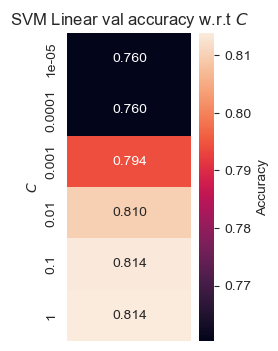

Trial # =  1
(8000, 7) (2000, 7) (8000,) (2000,)


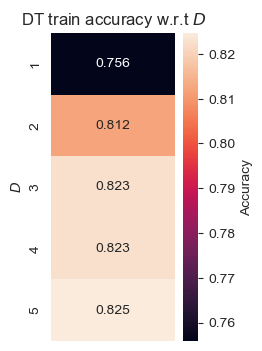

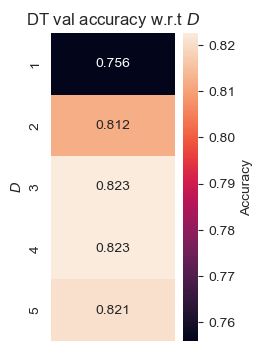

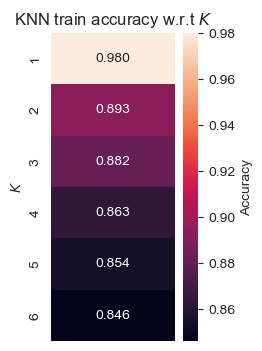

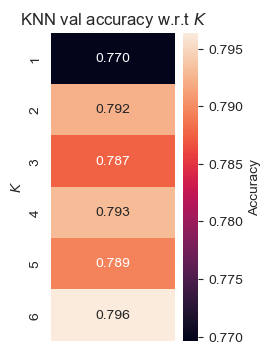

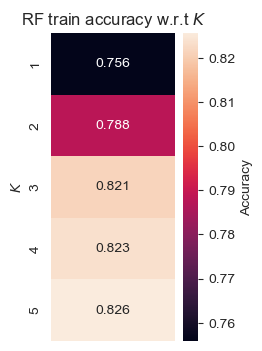

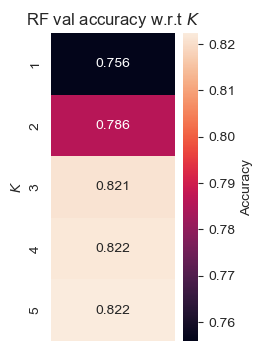

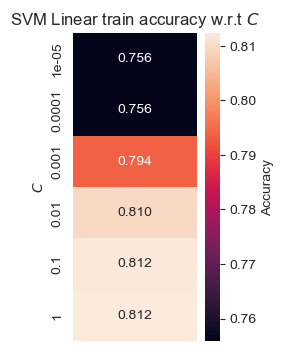

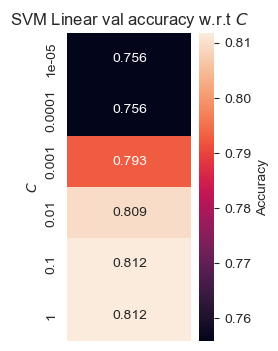

Trial # =  2
(8000, 7) (2000, 7) (8000,) (2000,)


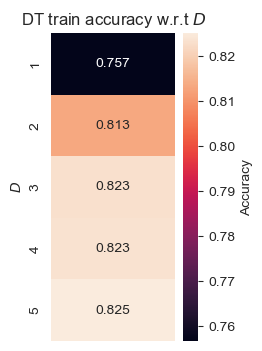

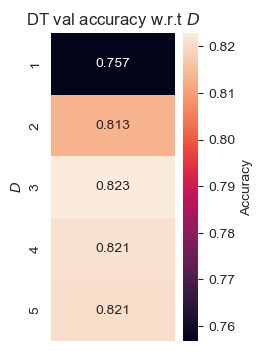

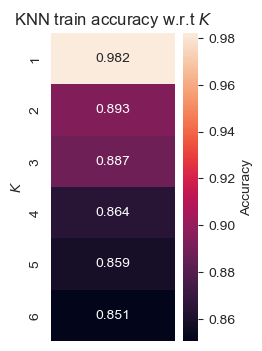

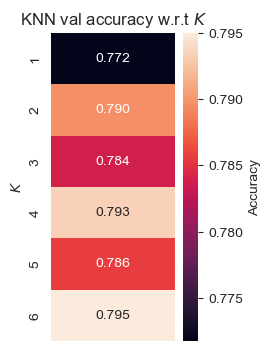

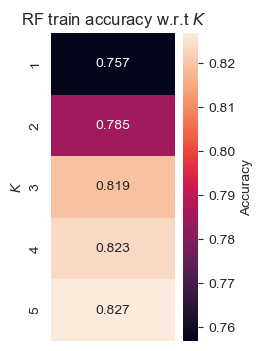

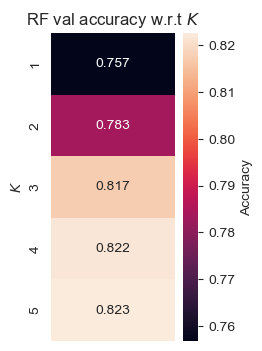

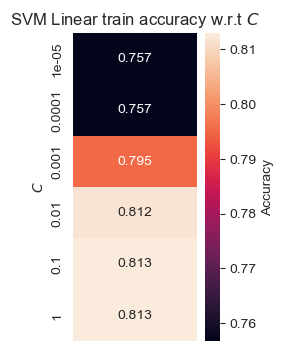

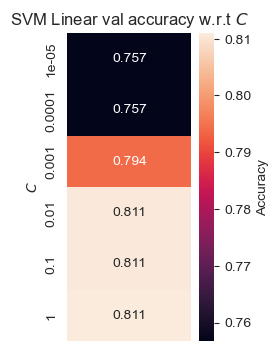

Trial # =  3
Avg Test Accuracy for Decision Tree (DT) =  0.8273333333333334
Avg Test Accuracy for KNN =  0.8076666666666666
Avg Test Accuracy for Random Forest =  0.8275
Avg Test Accuracy for SVM Linear =  0.8146666666666667


In [12]:
#List partitions: 20/80, 50/50, 80/20
partition_nums = [0.2, 0.5, 0.8]

#Prepare result tables: test accuracy, best training accuracy, best parameter
test_acc_table = np.zeros((3,4))
best_train_table = np.zeros((3,4))
best_param_table = np.zeros((3,4))

#Perform classification over number of trials

for i, partition in enumerate(partition_nums):
    print("Partition: ", partition)
    
    #Prepare arrays to hold the test accuracies from each classifier
    DT_test_acc = []
    KNN_test_acc = []
    RF_test_acc = []
    SVM_test_acc = []
    
    #3 trials per partition
    num_trials = 3
    
    #Begin conducting trials and performing classification
    for trial in range(num_trials):
        #Shuffle the data to ensure randomization
        np.random.shuffle(data)
        
        #Find the partition point
        breakNum = int(partition * len(data))
        
        #Make the training and testing sets
        X_train_val = data[:breakNum,:-1]
        Y_train_val = data[:breakNum,-1]
        X_test = data[breakNum:,:-1]
        Y_test = data[breakNum:,-1]
        
        print(X_train_val.shape, X_test.shape, Y_train_val.shape, Y_test.shape)
        
        #Now we call the classifier functions defined in Step 2
        #After each function call, append the test accuracy to the appropriate array
        
        #Decision Tree Classifier
        test_acc, DT_best_train, DT_best_param = decision_tree(X_train_val, Y_train_val, X_test, Y_test)
        DT_test_acc.append(test_acc)
        
        #KNN Classifier
        test_acc, KNN_best_train, KNN_best_param = knn_classifier(X_train_val, Y_train_val, X_test, Y_test)
        KNN_test_acc.append(test_acc)
        
        #Random Forest Classifier
        test_acc, RF_best_train, RF_best_param = random_forest(X_train_val, Y_train_val, X_test, Y_test)
        RF_test_acc.append(test_acc)
        
        #SVM linear Classifier
        test_acc, SVM_best_train, SVM_best_param = svm_linear(X_train_val, Y_train_val, X_test, Y_test)
        SVM_test_acc.append(test_acc)
        
        print("Trial # = ", trial + 1)

    #Calculate the average test accuracies across the trials for each classifier
    DT_avg_test_acc = sum(DT_test_acc)/num_trials
    KNN_avg_test_acc = sum(KNN_test_acc)/num_trials
    RF_avg_test_acc = sum(RF_test_acc)/num_trials
    SVM_avg_test_acc = sum(SVM_test_acc)/num_trials
    
    #Fill in test_acc table with average test accuracy for each classifier
    test_acc_table[i,0] = DT_avg_test_acc
    test_acc_table[i,1] = KNN_avg_test_acc
    test_acc_table[i,2] = RF_avg_test_acc
    test_acc_table[i,3] = SVM_avg_test_acc
    
    #Fill in best_train table with best training accuracy for each classifier
    best_train_table[i,0] = DT_best_train
    best_train_table[i,1] = KNN_best_train
    best_train_table[i,2] = RF_best_train
    best_train_table[i,3] = SVM_best_train
    
    #Fill in best_param table with best hyperparameter for each classifier
    best_param_table[i,0] = DT_best_param
    best_param_table[i,1] = KNN_best_param
    best_param_table[i,2] = RF_best_param
    best_param_table[i,3] = SVM_best_param
    
    #Print out average test accuracies for the trials for each classifier
    print("Avg Test Accuracy for Decision Tree (DT) = ", DT_avg_test_acc)
    print("Avg Test Accuracy for KNN = ", KNN_avg_test_acc)
    print("Avg Test Accuracy for Random Forest = ", RF_avg_test_acc)
    print("Avg Test Accuracy for SVM Linear = ", SVM_avg_test_acc)

In [13]:
#Print out tables
print("Y-axis: partitions = 20/80, 50/50, 80/20")
print("X-axis: classifiers = Decision Tree, KNN, Random Forest, SVM Linear")
print("-----------------------------------------------------------------------")
print("Test Accuracy Table")
print(test_acc_table)
print("-----------------------------------------------------------------------")
print("Best Training Accuracy Table")
print(best_train_table)
print("-----------------------------------------------------------------------")
print("Best Parameter Table")
print(best_param_table)

Y-axis: partitions = 20/80, 50/50, 80/20
X-axis: classifiers = Decision Tree, KNN, Random Forest, SVM Linear
-----------------------------------------------------------------------
Test Accuracy Table
[[0.823625   0.784      0.82308333 0.81345833]
 [0.8246     0.79573333 0.82426667 0.81286667]
 [0.82733333 0.80766667 0.8275     0.81466667]]
-----------------------------------------------------------------------
Best Training Accuracy Table
[[0.84       0.844625   0.8415     0.815875  ]
 [0.83545    0.85085    0.8306     0.8175    ]
 [0.823125   0.85053125 0.82678125 0.8129375 ]]
-----------------------------------------------------------------------
Best Parameter Table
[[5.  6.  5.  0.1]
 [5.  6.  4.  0.1]
 [3.  6.  5.  1. ]]
